# Telco Churn Project

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from separate_library import prep_data, split_data, scale_data

from scipy import stats

import acquire as ac
import prepare as pr

import warnings
warnings.filterwarnings("ignore")

---
# Acquire

In [2]:
df = ac.get_telco_data()
df.shape

(7043, 24)

In [3]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,internet_service_type,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,DSL,No,No,No,No,No,Yes,1,Month-to-month,No,2,Mailed check,59.9,542.4,No
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,DSL,No,No,No,Yes,Yes,Yes,1,Month-to-month,Yes,4,Credit card (automatic),69.4,571.45,No
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,DSL,Yes,No,No,No,No,No,1,Month-to-month,Yes,1,Electronic check,48.2,340.35,No
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,DSL,No,No,No,No,No,No,1,Month-to-month,Yes,1,Electronic check,25.1,25.1,Yes
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,DSL,Yes,No,No,No,No,No,1,Month-to-month,No,3,Bank transfer (automatic),30.5,30.5,Yes


In [4]:
df.describe()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,1.872923,1.690473,2.315633,64.761692
std,0.368612,24.559481,0.737796,0.833755,1.148907,30.090047
min,0.000000,0.000000,1.000000,1.000000,1.000000,18.250000
25%,0.000000,9.000000,1.000000,1.000000,1.000000,35.500000
50%,0.000000,29.000000,2.000000,1.000000,2.000000,70.350000
75%,0.000000,55.000000,2.000000,2.000000,3.000000,89.850000
max,1.000000,72.000000,3.000000,3.000000,4.000000,118.750000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
internet_service_type_id    7043 non-null int64
internet_service_type       7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
contract_type_id            7043 non-null int64
contract_type               7043 non-null object
paperless_billi

## Observations
- No null values. That's good. Perhaps too good to be true.
- total_charges is an object. Needs to be a float.

In [6]:
df[df.total_charges == " "]

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,internet_service_type,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn
5086,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,3,None,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,2,One year,Yes,2,Mailed check,19.70,,No
5433,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,1,DSL,Yes,Yes,Yes,Yes,Yes,No,3,Two year,No,4,Credit card (automatic),56.05,,No
5504,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,1,DSL,Yes,Yes,No,Yes,No,No,3,Two year,Yes,3,Bank transfer (automatic),61.90,,No
5584,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,1,DSL,No,Yes,Yes,Yes,Yes,No,3,Two year,No,2,Mailed check,73.35,,No
5603,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,1,DSL,Yes,No,Yes,Yes,Yes,No,3,Two year,Yes,3,Bank transfer (automatic),52.55,,No
5687,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,1,DSL,Yes,Yes,Yes,No,Yes,Yes,3,Two year,No,2,Mailed check,80.85,,No
6569,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,3,None,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Two year,No,2,Mailed check,20.00,,No
6605,3115-CZMZD,Male,0,No,Yes,0,Yes,No,3,None,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Two year,No,2,Mailed check,20.25,,No
6615,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,3,None,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Two year,No,2,Mailed check,25.35,,No
6686,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,3,None,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Two year,No,2,Mailed check,25.75,,No


## Decision
- There are only 11 rows that are blank in the total_charges feature. We can probably drop those rows.
- total_charges will be converted to a float type in preparation.

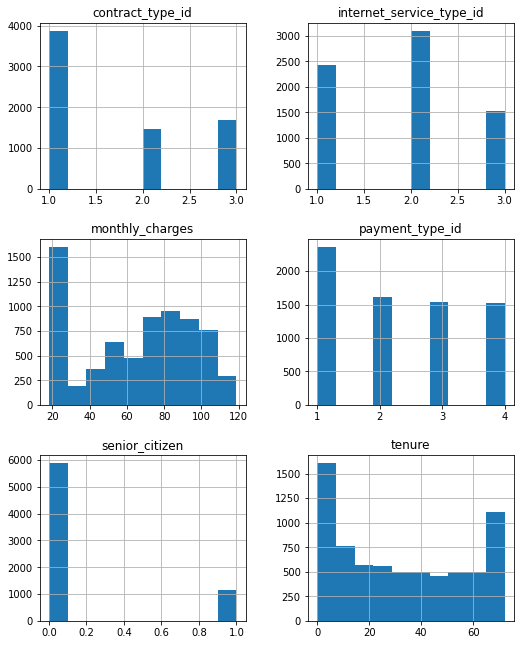

In [7]:
df.hist(figsize=(8.5, 11))
plt.show()

---
# Prepare

## Explanation of prep_telco function
- The function below does the following:
 1. Drops the rows where the total_charges feature initally contained blank strings, and converts the feature to a float type.
 2. Consolidates some of the inital features in the original data that were redudant or related.
     - New feauture: phone_service_type 
         - Purpose: Eliminates necessity of phone_service and multiple lines features
     - New feauture: family 
         - Purpose: Eliminates necessity of partner and dependents features
     - New feauture: streaming 
         - Purpose: Eliminates necessity of streaming_tv and streaming_movies features
     - New feauture: online_protection 
         - Purpose: Eliminates necessity of online_security and online_backup features
 3. Splits the orignial DataFrame in to train, validate, and test.
 4. Calculates tenure_years for the train data set
 5. Encodes churn
 6. Returns the encoder object, train data set, validate data set, and test data set

In [8]:
encoder, train, validate, test = pr.prep_telco(df)
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (4218, 21)
validate shape = (1407, 20)
    test shape = (1407, 20)


In [9]:
train.head()

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years
5767,6885-PKOAM,Female,0,71,1,DSL,Yes,Yes,3,Two year,No,4,Credit card (automatic),85.75,6223.80,0,Multiple lines,Partner,TV and movies,Security and backup,6.0
601,4923-ADWXJ,Female,0,25,1,DSL,No,Yes,1,Month-to-month,Yes,3,Bank transfer (automatic),65.80,1679.65,0,Single line,Single,Movies,Backup,2.0
6469,1099-GODLO,Female,0,1,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,20.35,20.35,0,Single line,Partner and dependents,No internet service,No internet service,0.0
5729,6374-AFWOX,Male,0,46,1,DSL,Yes,Yes,3,Two year,No,2,Mailed check,65.65,3047.15,0,Single line,Partner,None,Security and backup,4.0
1163,9489-UTFKA,Male,1,8,1,DSL,No,No,1,Month-to-month,No,3,Bank transfer (automatic),60.90,551.95,0,Single line,Partner,TV,Security,1.0


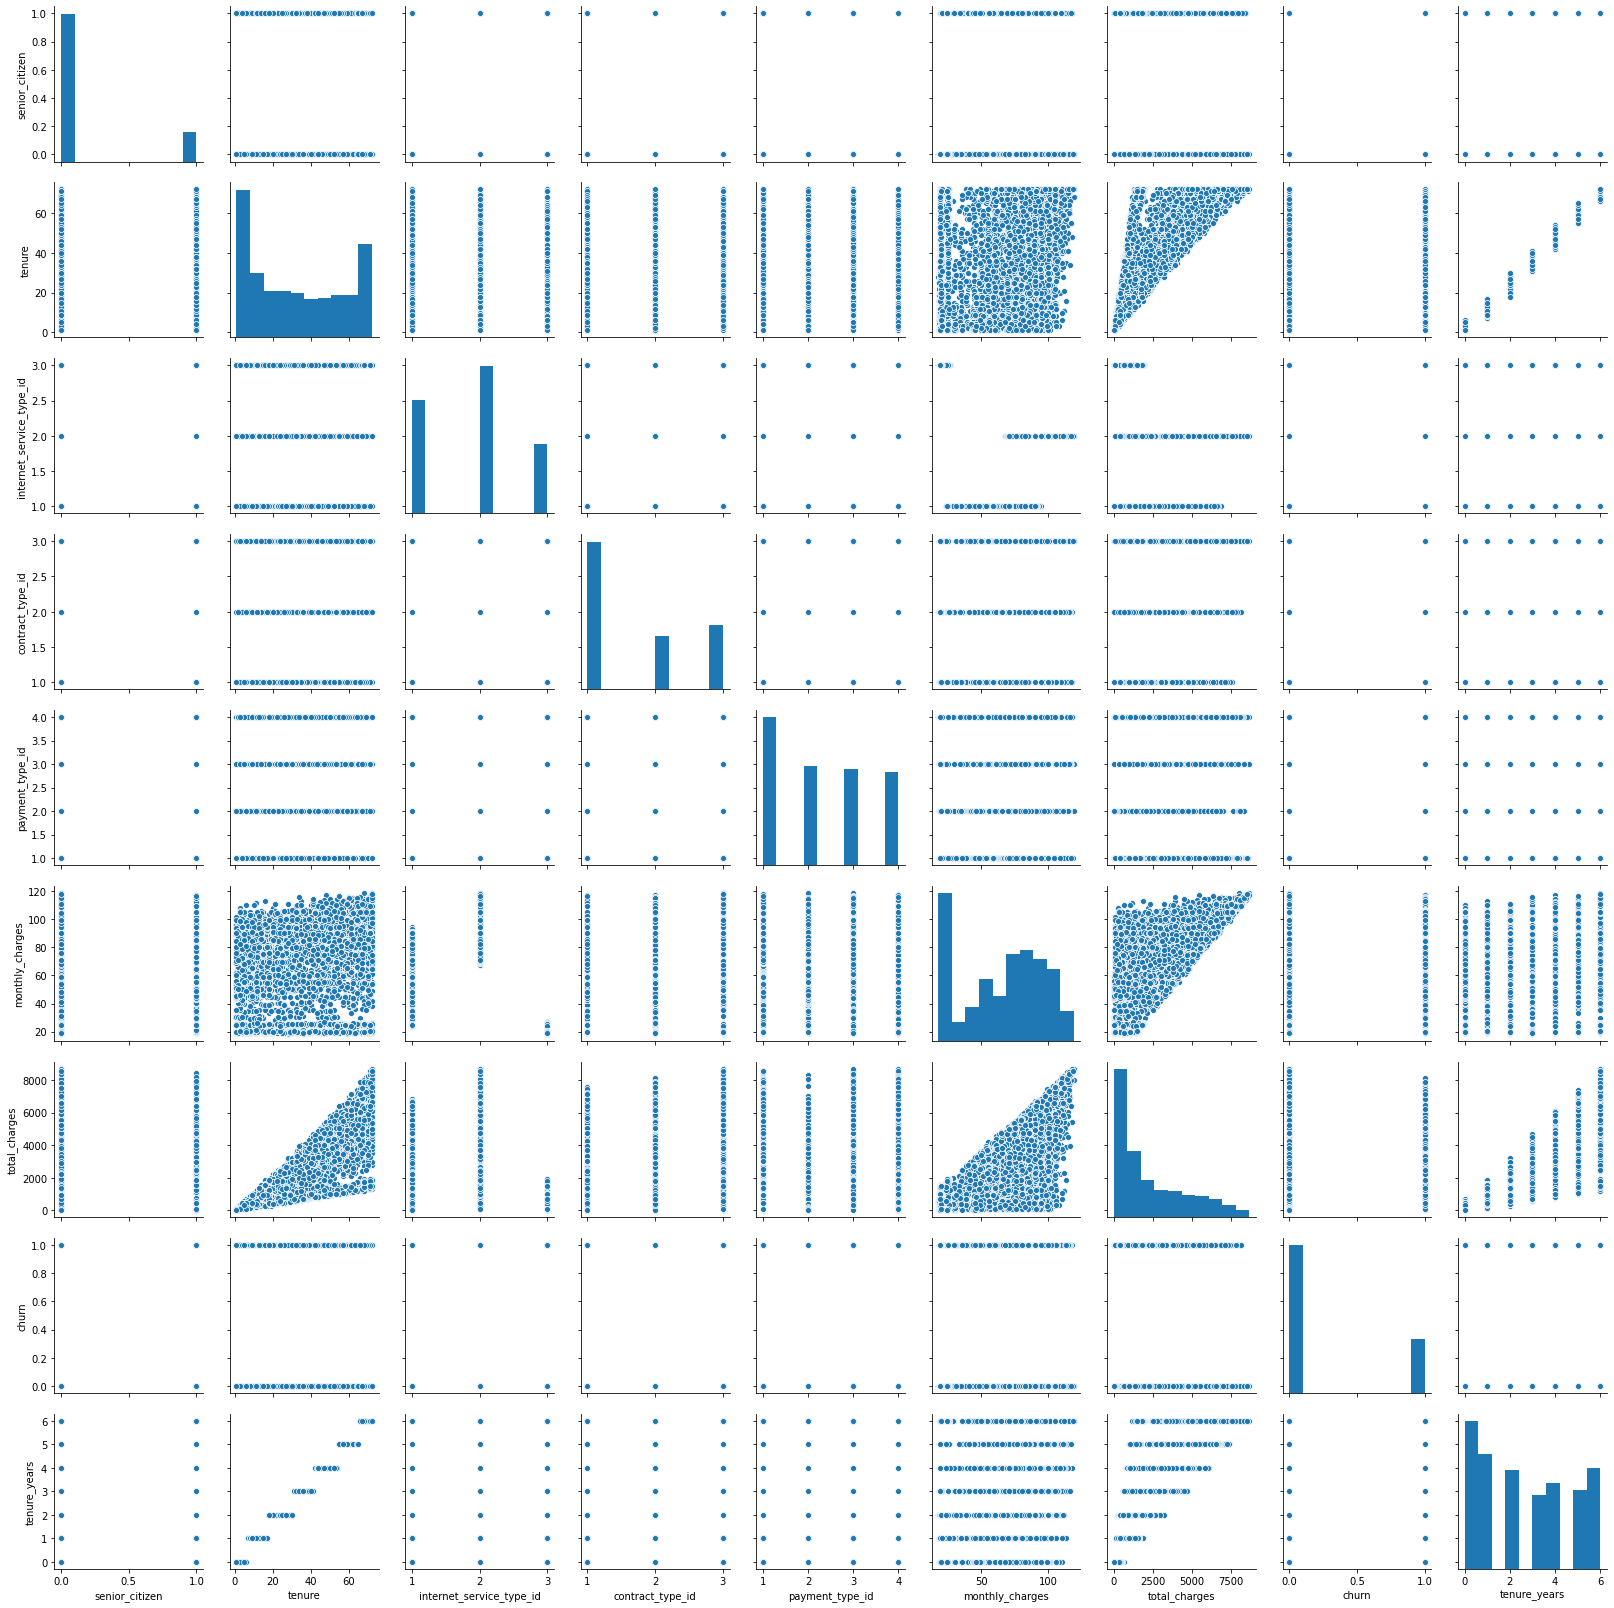

In [10]:
sns.pairplot(train)
plt.show()

---
# Explore

## 1. Are there clear groupings where a customer is more likely to churn? What if you consider contract type? Is there a tenure that month-to-month customers are most likely to churn? 1-year contract customers? 2-year customers? Do you have any thoughts on what could be going on?

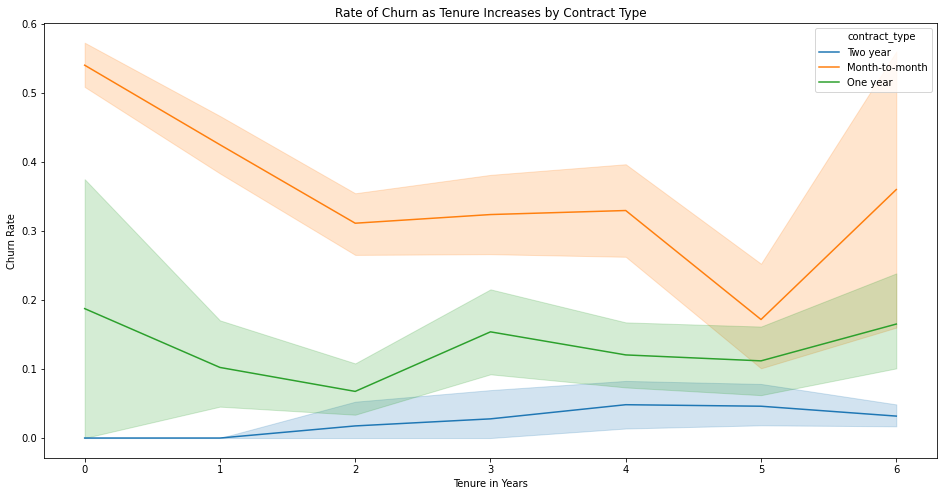

In [11]:
plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases by Contract Type")
sns.lineplot(x=train.tenure_years, y=train.churn, hue=train.contract_type)
plt.xlabel("Tenure in Years")
plt.ylabel("Churn Rate")
plt.show()

> **I posit that month-to-month and one year customers are most likely to churn within the first year of service.**

> **I posit that two year contract customers are most likely to churn in the fourth and fifth years of service.**

## 2. If a group is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?

$H_0$: The churn rate for customers whose tenure is less than or equal to one year is the same as all other customers

$H_a$: The churn rate for customers whose tenure is less than or equal to one year is different than all other customers

In [12]:
alpha = .001

x = train[train.tenure_years <= 1].churn
mu = train.churn.mean()

tstat, p = stats.ttest_1samp(x, mu)
print(f"t statistic = {tstat}")
print(f"    p-value = {p}")
print()
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")
print()
print("""There is a difference in the churn rate for customers whose tenure is less than or equal to one year when
compared to all other customers.""")

t statistic = 14.767252115963558
    p-value = 2.5543291149045378e-46

Reject the null hypothesis

There is a difference in the churn rate for customers whose tenure is less than or equal to one year when
compared to all other customers.


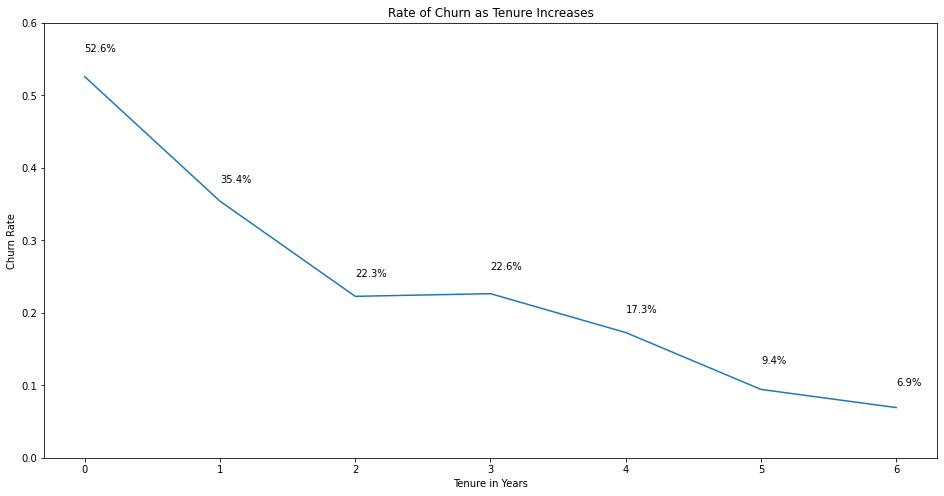

In [13]:
# plotting churn rate by tenure years
yearly = pd.DataFrame({
    "tenure": np.sort(train.tenure_years.unique()),
})

yearly["churn_rate"] = [((train.churn == 1) & (train.tenure_years == n)).sum() / (train.tenure_years == n).sum() for n in yearly.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(yearly.tenure, yearly.churn_rate)
plt.text(0, .56, f"{train[train.tenure_years == 0].churn.mean():.1%}")
plt.text(1, .38, f"{train[train.tenure_years == 1].churn.mean():.1%}")
plt.text(2, .25, f"{train[train.tenure_years == 2].churn.mean():.1%}")
plt.text(3, .26, f"{train[train.tenure_years == 3].churn.mean():.1%}")
plt.text(4, .20, f"{train[train.tenure_years == 4].churn.mean():.1%}")
plt.text(5, .13, f"{train[train.tenure_years == 5].churn.mean():.1%}")
plt.text(6, .10, f"{train[train.tenure_years == 6].churn.mean():.1%}")
plt.xlabel("Tenure in Years")
plt.ylabel("Churn Rate")
plt.ylim(0, .6)
plt.show()

> **Clearly, the rate of churn declines as the customer's tenure with the company increases.**

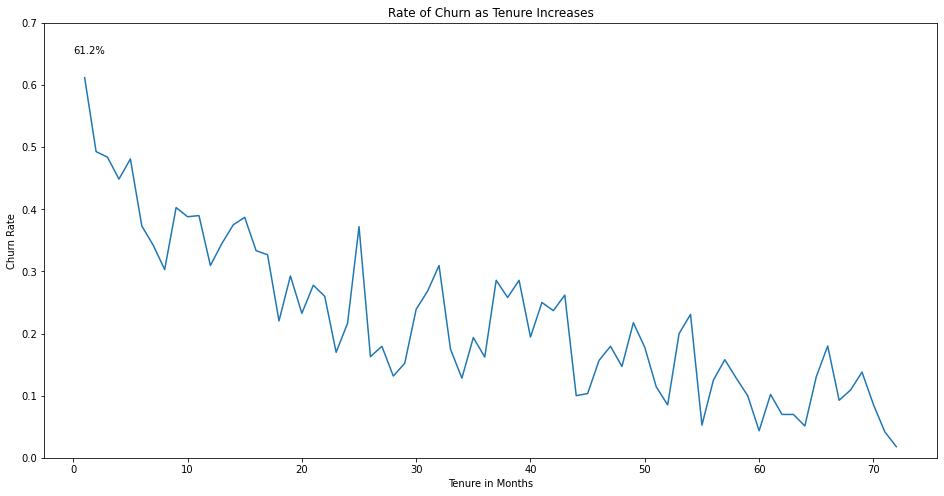

In [14]:
# plotting churn rate by tenure months
monthly = pd.DataFrame({
    "tenure": np.sort(train.tenure.unique()),
})

monthly["churn_rate"] = [((train.churn == 1) & (train.tenure == n)).sum() / (train.tenure == n).sum() for n in monthly.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(monthly.tenure, monthly.churn_rate)
plt.text(0, .65, f"{train[train.tenure == 1].churn.mean():.1%}")
plt.xlabel("Tenure in Months")
plt.ylabel("Churn Rate")
plt.ylim(0, .7)
plt.show()

> **The chart above visualizes the rate of churn by tenure in months.**

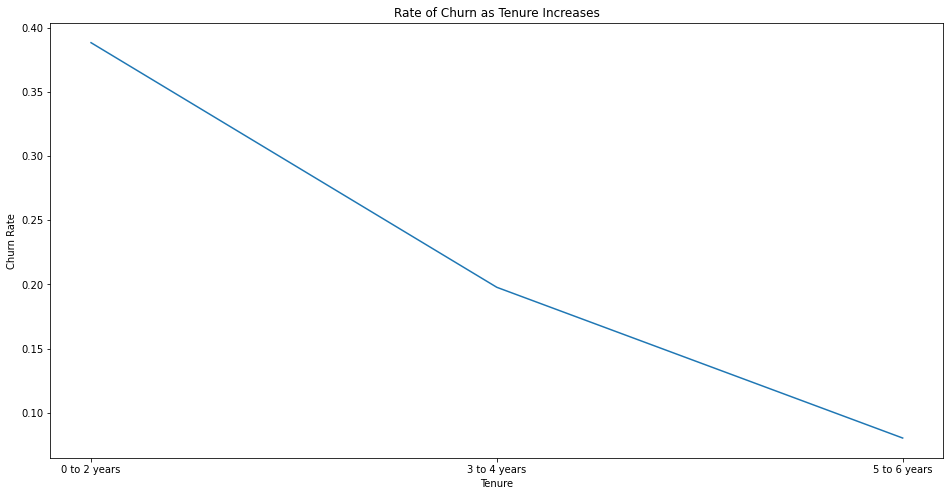

In [15]:
# plotting churn rate by tenure years binned
train["tenure_years_binned"] = pd.cut(train.tenure_years, bins=3, labels=["0 to 2 years", "3 to 4 years", "5 to 6 years"])

binned = pd.DataFrame({
    "tenure": np.sort(train.tenure_years_binned.unique()),
})

binned["churn_rate"] = [((train.churn == 1) & (train.tenure_years_binned == b)).sum() / (train.tenure_years_binned == b).sum() for b in binned.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(binned.tenure, binned.churn_rate)
plt.xlabel("Tenure")
plt.ylabel("Churn Rate")
plt.show()

> **The chart above visualizes the rate of churn by tenure years binned.**

---
## 3. Are there features that indicate a higher propensity to churn? 

### Churn Rate by Internet Service Type

<Figure size 1152x576 with 0 Axes>

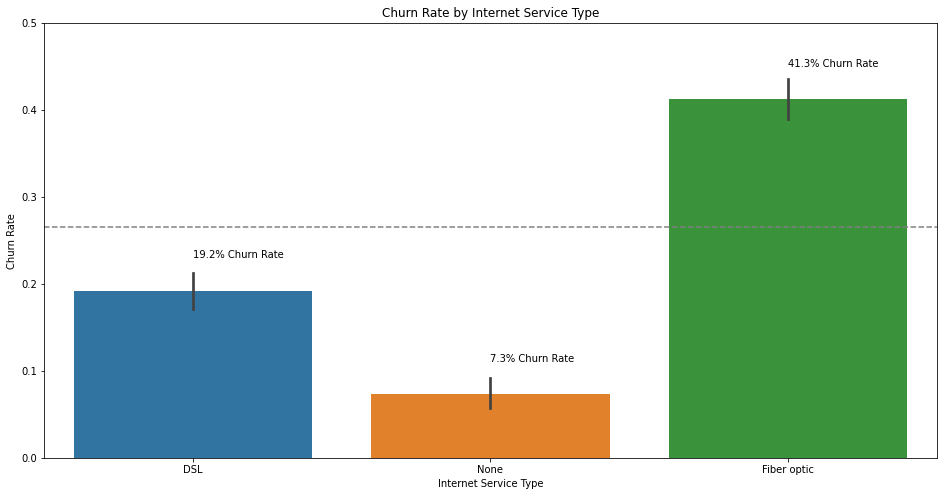

In [16]:
plt.figure(figsize=(16, 8))

ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

churn_rate = train.churn.mean()

plt.title("Churn Rate by Internet Service Type")
sns.barplot(train.internet_service_type, train.churn)
ax[1].axhline(churn_rate, ls='--', color='grey')
plt.text(0, .23, f"{train[train.internet_service_type == 'DSL'].churn.mean():.1%} Churn Rate")
plt.text(1, .11, f"{train[train.internet_service_type == 'None'].churn.mean():.1%} Churn Rate")
plt.text(2, .45, f"{train[train.internet_service_type == 'Fiber optic'].churn.mean():.1%} Churn Rate")
plt.xlabel("Internet Service Type")
plt.ylabel("Churn Rate")
plt.ylim(0, .5)
plt.show()

> **Fiber optic internet service type seems to be a driver of churn. 41.3% of the customers with fiber optic internet service are likely to churn. This is not a good thing! I would anticipate that DSL would have had a higher churn rate due to the technology being generally inferior to fiber optic. We need to heavily invest in developing our fiber optic network.**

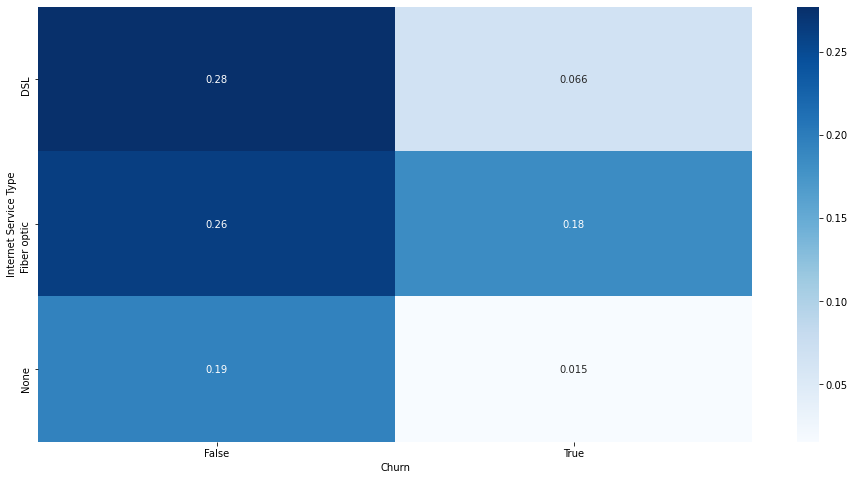

In [17]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.internet_service_type, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Internet Service Type")
plt.xticks((.5, 1.5), (False, True))
plt.show()

> **Customers who are using fiber optic internet service and have churned make up 18% of all customers.**

---
### Churn Rate by Phone Service Type

<Figure size 1152x576 with 0 Axes>

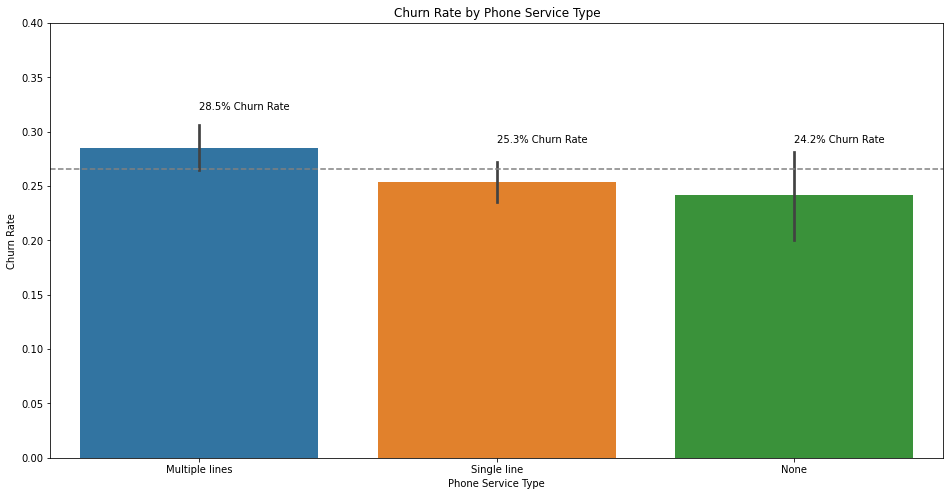

In [18]:
plt.figure(figsize=(16, 8))

ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

churn_rate = train.churn.mean()

plt.title("Churn Rate by Phone Service Type")
sns.barplot(train.phone_service_type, train.churn)
ax[1].axhline(churn_rate, ls='--', color='grey')
plt.text(0, .32, f"{train[train.phone_service_type == 'Multiple lines'].churn.mean():.1%} Churn Rate")
plt.text(1, .29, f"{train[train.phone_service_type == 'Single line'].churn.mean():.1%} Churn Rate")
plt.text(2, .29, f"{train[train.phone_service_type == 'None'].churn.mean():.1%} Churn Rate")
plt.xlabel("Phone Service Type")
plt.ylabel("Churn Rate")
plt.ylim(0, .4)
plt.show()

> **There does not seem to be a significant difference in the churn rate when considering the phone service type**

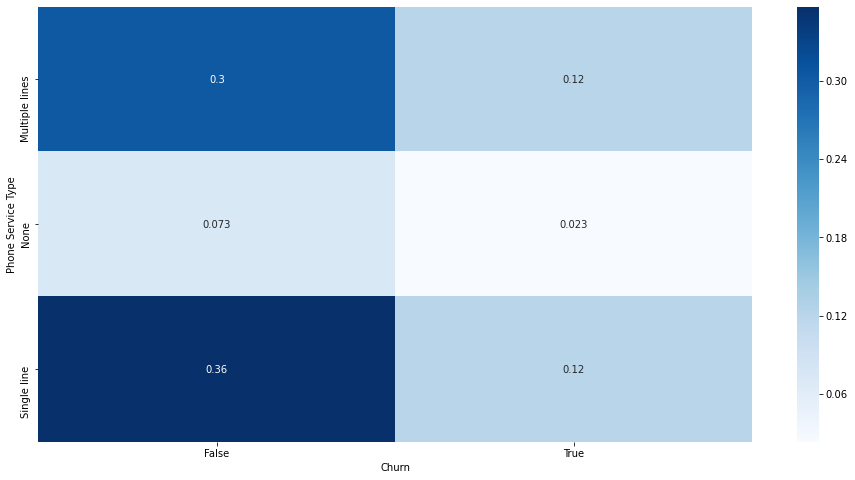

In [19]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.phone_service_type, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Phone Service Type")
plt.xticks((.5, 1.5), (False, True))
plt.show()

---
### Churn Rate by Online Protection

<Figure size 1152x576 with 0 Axes>

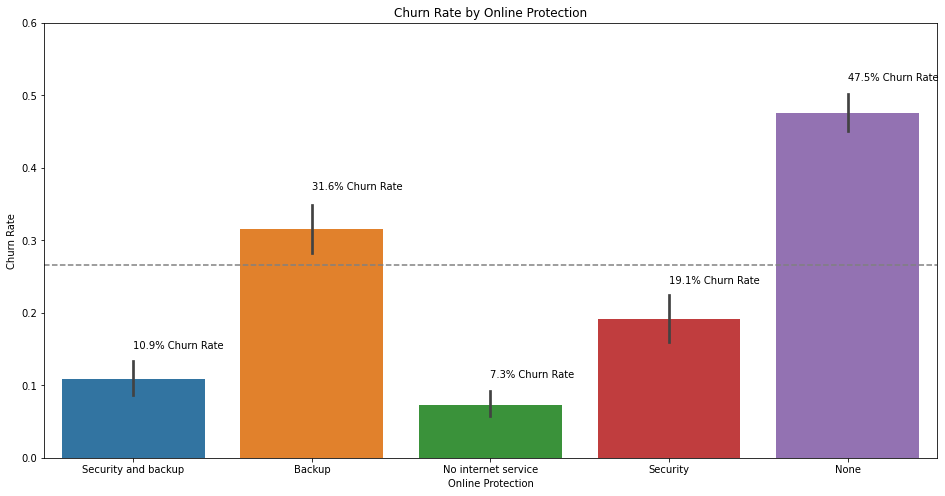

In [20]:
plt.figure(figsize=(16, 8))

ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

churn_rate = train.churn.mean()

plt.title("Churn Rate by Online Protection")
sns.barplot(train.online_protection, train.churn)
ax[1].axhline(churn_rate, ls='--', color='grey')
plt.text(0, .15, f"{train[train.online_protection == 'Security and backup'].churn.mean():.1%} Churn Rate")
plt.text(1, .37, f"{train[train.online_protection == 'Backup'].churn.mean():.1%} Churn Rate")
plt.text(2, .11, f"{train[train.online_protection == 'No internet service'].churn.mean():.1%} Churn Rate")
plt.text(3, .24, f"{train[train.online_protection == 'Security'].churn.mean():.1%} Churn Rate")
plt.text(4, .52, f"{train[train.online_protection == 'None'].churn.mean():.1%} Churn Rate")
plt.xlabel("Online Protection")
plt.ylabel("Churn Rate")
plt.ylim(0, .6)
plt.show()

> **47.5% of the customers that have no online protection churn.**

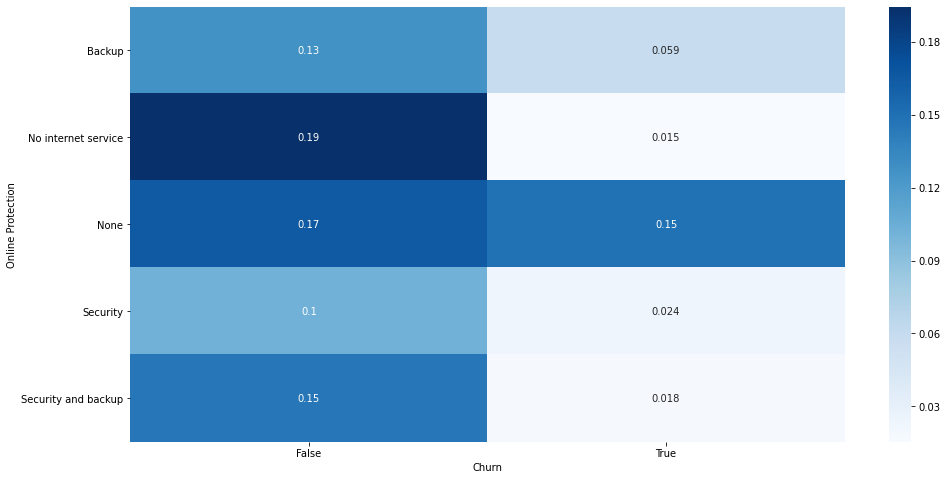

In [21]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.online_protection, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Online Protection")
plt.xticks((.5, 1.5), (False, True))
plt.show()

> **Customers who have no online protection plan and who have churned make up 15% of all customers.**

---
### Churn Rate by Senior Citizen Status

<Figure size 1152x576 with 0 Axes>

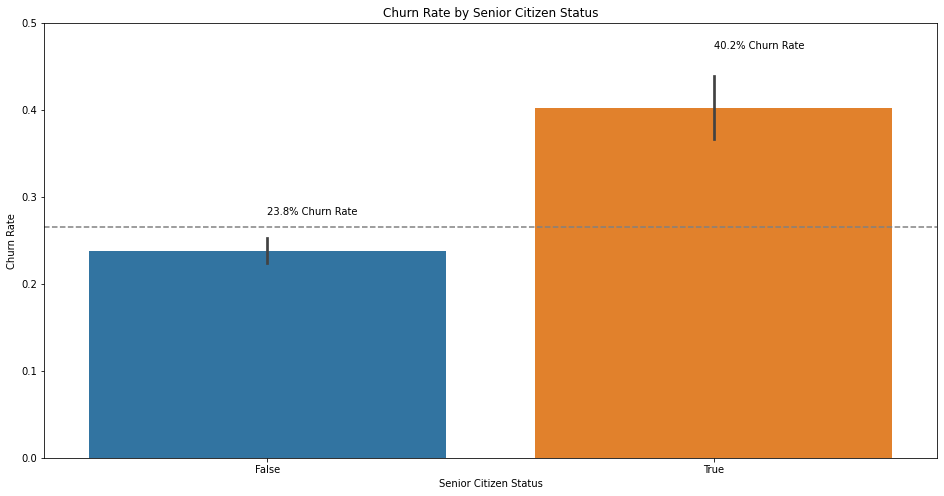

In [22]:
plt.figure(figsize=(16, 8))

ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

churn_rate = train.churn.mean()

plt.title("Churn Rate by Senior Citizen Status")
sns.barplot(train.senior_citizen, train.churn)
ax[1].axhline(churn_rate, ls='--', color='grey')
plt.text(0, .28, f"{train[train.senior_citizen == 0].churn.mean():.1%} Churn Rate")
plt.text(1, .47, f"{train[train.senior_citizen == 1].churn.mean():.1%} Churn Rate")
plt.xlabel("Senior Citizen Status")
plt.ylabel("Churn Rate")
plt.xticks((0, 1), (False, True))
plt.ylim(0, .5)
plt.show()

> **40.2% of all senior citizens churn.**

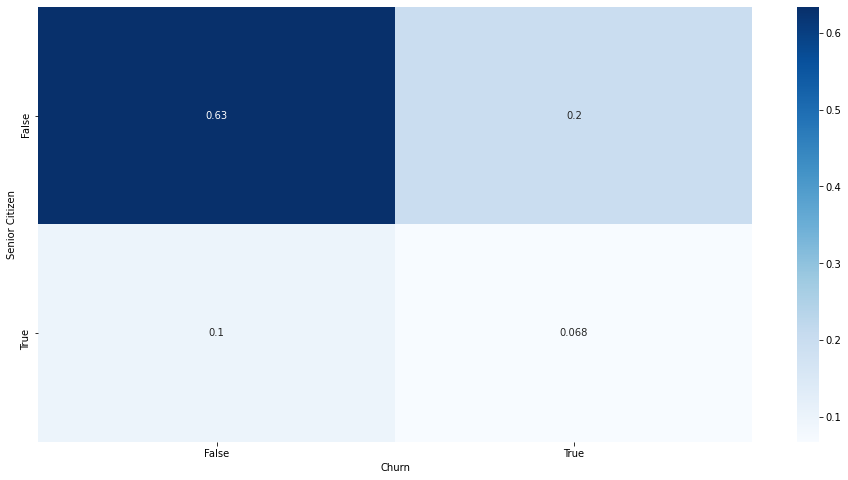

In [23]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.senior_citizen, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Senior Citizen")
plt.yticks((.5, 1.5), (False, True))
plt.xticks((.5, 1.5), (False, True))
plt.show()

> **Customers who are not senior citizens and who have churned make up 20% of all customers.**

---
## 4. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

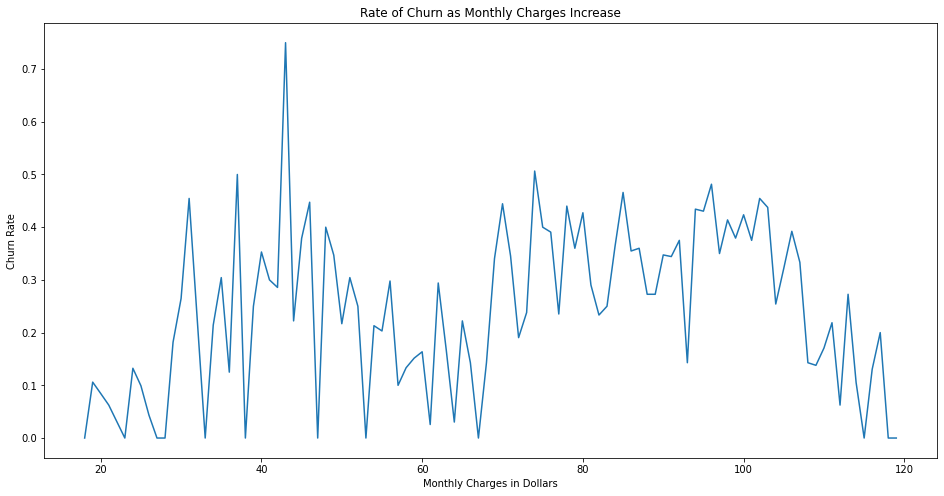

In [24]:
# plotting churn rate by monthly_charges
monthly_charges = pd.DataFrame({
    "charges": np.sort(train.monthly_charges.round().unique()),
})

monthly_charges["churn_rate"] = [train[train.monthly_charges.round() == n].churn.mean() for n in monthly_charges.charges]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Monthly Charges Increase")
plt.plot(monthly_charges.charges, monthly_charges.churn_rate)
plt.xlabel("Monthly Charges in Dollars")
plt.ylabel("Churn Rate")
plt.show()

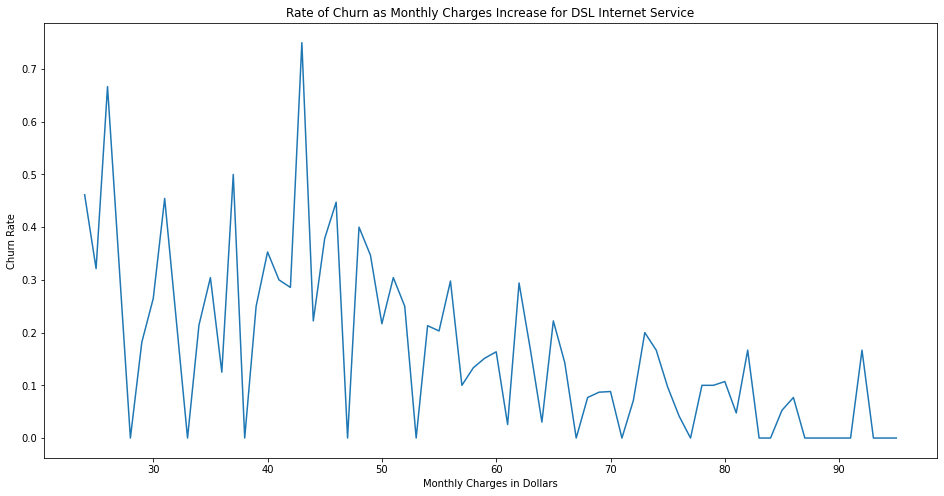

In [25]:
# plotting churn rate by monthly_charges DSL internet service
DSL_monthly_charges = pd.DataFrame({
    "charges": np.sort(train[train.internet_service_type == "DSL"].monthly_charges.round().unique()),
})

DSL_monthly_charges["churn_rate"] = [train[(train.internet_service_type == "DSL") & (train.monthly_charges.round() == n)].churn.mean() for n in DSL_monthly_charges.charges]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Monthly Charges Increase for DSL Internet Service")
plt.plot(DSL_monthly_charges.charges, DSL_monthly_charges.churn_rate)
plt.xlabel("Monthly Charges in Dollars")
plt.ylabel("Churn Rate")
plt.show()

> **There does not appear to be a price threshold at which churn significantly increases for DSL internet service**

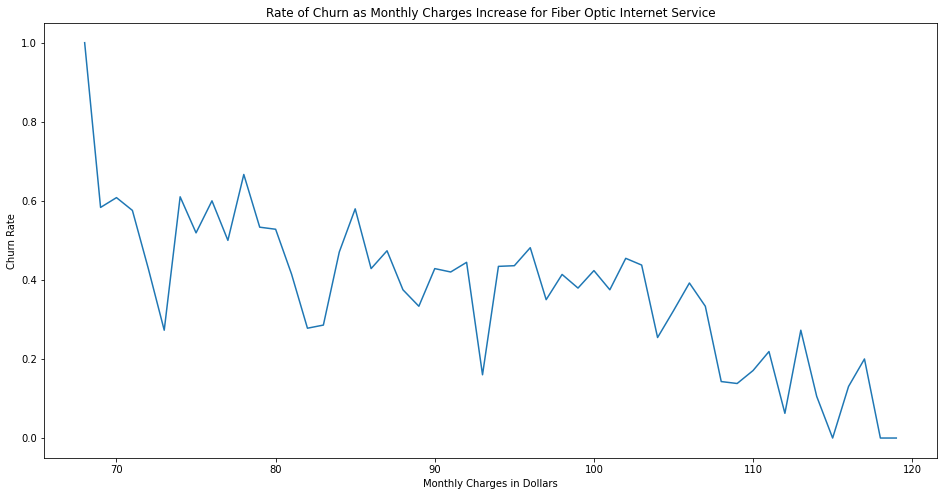

In [26]:
# plotting churn rate by monthly_charges for fiber optic internet service
fiber_optic_monthly_charges = pd.DataFrame({
    "charges": np.sort(train[train.internet_service_type == "Fiber optic"].monthly_charges.round().unique()),
})

fiber_optic_monthly_charges["churn_rate"] = [train[(train.internet_service_type == "Fiber optic") & (train.monthly_charges.round() == n)].churn.mean() for n in fiber_optic_monthly_charges.charges]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Monthly Charges Increase for Fiber Optic Internet Service")
plt.plot(fiber_optic_monthly_charges.charges, fiber_optic_monthly_charges.churn_rate)
plt.xlabel("Monthly Charges in Dollars")
plt.ylabel("Churn Rate")
plt.show()

> **37.7% of customers paying more than $78 a month for fiber optic internet service churn.**

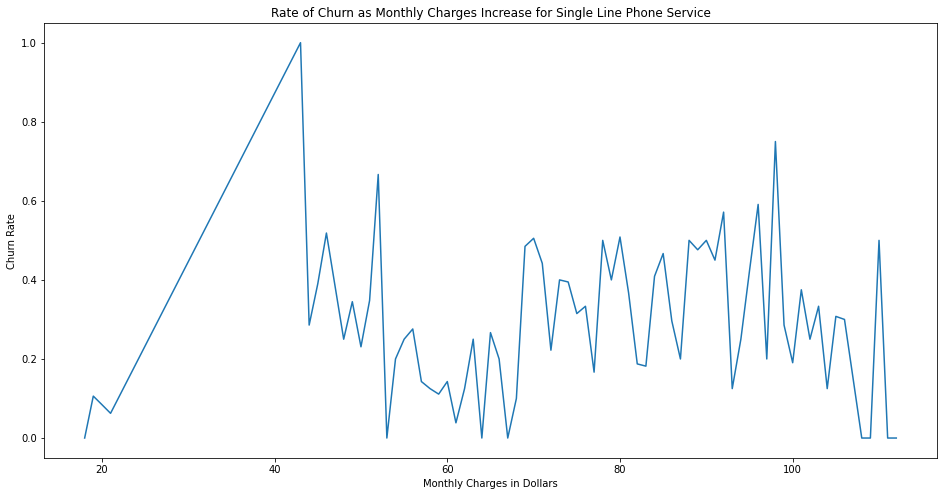

In [27]:
# plotting churn rate by monthly_charges for single line phone service
single_line_monthly_charges = pd.DataFrame({
    "charges": np.sort(train[train.phone_service_type == "Single line"].monthly_charges.round().unique()),
})

single_line_monthly_charges["churn_rate"] = [train[(train.phone_service_type == "Single line") & (train.monthly_charges.round() == n)].churn.mean() for n in single_line_monthly_charges.charges]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Monthly Charges Increase for Single Line Phone Service")
plt.plot(single_line_monthly_charges.charges, single_line_monthly_charges.churn_rate)
plt.xlabel("Monthly Charges in Dollars")
plt.ylabel("Churn Rate")
plt.show()

> **39.4% of customers paying more than $68 a month for single line phone service churn.**

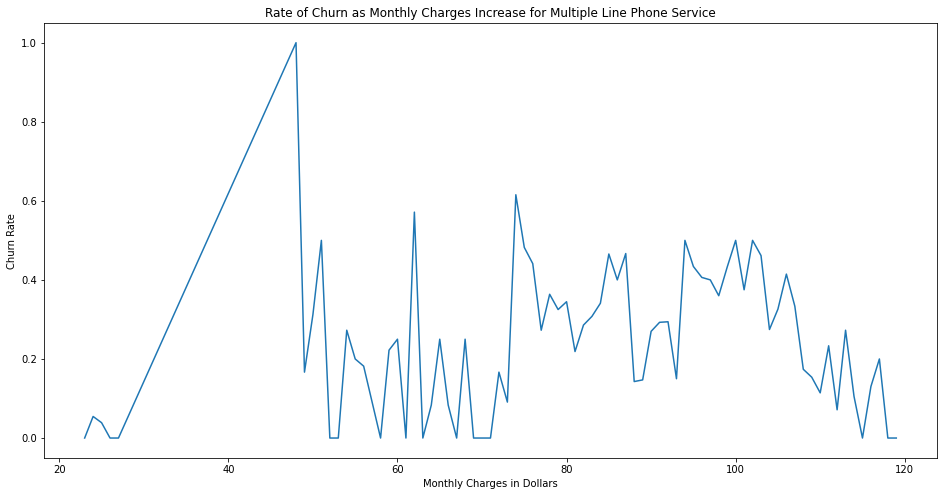

In [28]:
# plotting churn rate by monthly_charges for multiple line phone service
multi_line_monthly_charges = pd.DataFrame({
    "charges": np.sort(train[train.phone_service_type == "Multiple lines"].monthly_charges.round().unique()),
})

multi_line_monthly_charges["churn_rate"] = [train[(train.phone_service_type == "Multiple lines") & (train.monthly_charges.round() == n)].churn.mean() for n in multi_line_monthly_charges.charges]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Monthly Charges Increase for Multiple Line Phone Service")
plt.plot(multi_line_monthly_charges.charges, multi_line_monthly_charges.churn_rate)
plt.xlabel("Monthly Charges in Dollars")
plt.ylabel("Churn Rate")
plt.show()

> **33.5% of customers paying more than $70 a month for phone service with multiple lines churn.**

---
## 5. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

$H_0$: The churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month is the same

$H_a$: The churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month is different

In [29]:
alpha = .001

month_to_month = train[(train.contract_type == "Month-to-month") & (train.tenure == 13)].churn
annual = train[(train.contract_type == "One year") & (train.tenure == 13)].churn

tstat, p = stats.ttest_ind(month_to_month, annual)
print(f"t statistic = {tstat}")
print(f"    p-value = {p}")
print()
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")
print()
print(f"The churn rate for month-to-month customers after the 12th month is {month_to_month.mean():.1%}")
print(f"The churn rate for 1-year contract customers after the 12th month is {annual.mean():.1%}")
print()
print("""After the 12th month of service, month-to-month customers churn at almost 3x the rate of 1-year contract customers.""")

t statistic = 1.606828808496748
    p-value = 0.11426641673125218

Fail to reject the null hypothesis

The churn rate for month-to-month customers after the 12th month is 42.2%
The churn rate for 1-year contract customers after the 12th month is 12.5%

After the 12th month of service, month-to-month customers churn at almost 3x the rate of 1-year contract customers.


<Figure size 1152x576 with 0 Axes>

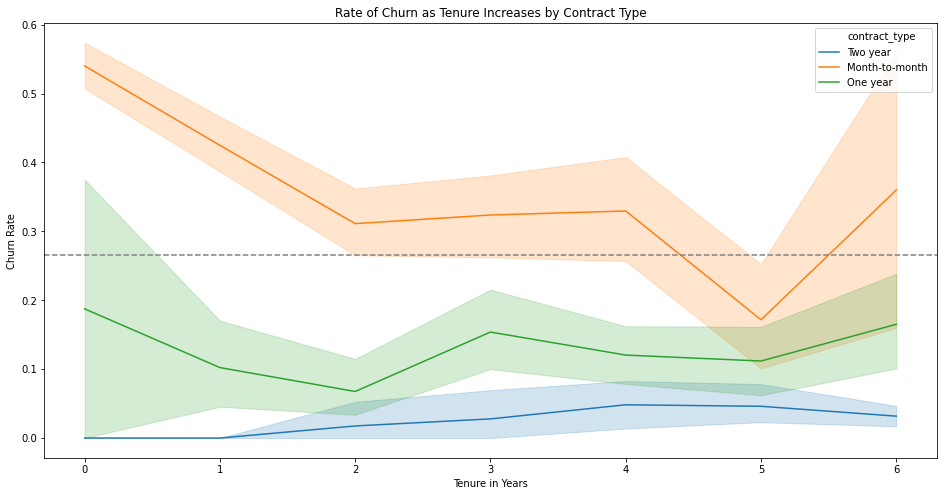

In [30]:
plt.figure(figsize=(16, 8))

ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

churn_rate = train.churn.mean()

plt.title("Rate of Churn as Tenure Increases by Contract Type")
sns.lineplot(x=train.tenure_years, y=train.churn, hue=train.contract_type)
ax[1].axhline(churn_rate, ls='--', color='grey')
plt.xlabel("Tenure in Years")
plt.ylabel("Churn Rate")
plt.show()

---
## 6. Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned?

$H_0$: The mean monthly charges between customers who have churned and those who have not churned are the same

$H_a$: The mean monthly charges between customers who have churned and those who have not churned are different

In [31]:
alpha = .001

churned = train[train.churn == 1].monthly_charges
not_churned = train[train.churn == 0].monthly_charges

tstat, p = stats.ttest_ind(churned, not_churned)
print(f"t statistic = {tstat}")
print(f"    p-value = {p}")
print()
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")
print()
print("""Monthly charges for customers who have churned are not the same""")

t statistic = 12.592938651105257
    p-value = 1.0075938137808398e-35

Reject the null hypothesis

Monthly charges for customers who have churned are not the same


<Figure size 1152x576 with 0 Axes>

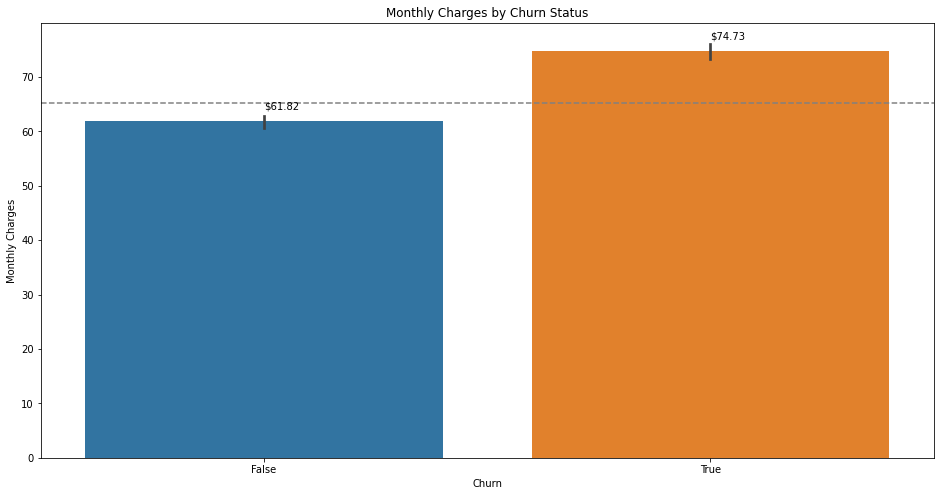

In [32]:
plt.figure(figsize=(16, 8))

ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

mean_monthly_charges = train.monthly_charges.mean()

plt.title("Monthly Charges by Churn Status")
sns.barplot(train.churn, train.monthly_charges)
ax[1].axhline(mean_monthly_charges, ls='--', color='grey')
plt.text(0, 64, f"${train[train.churn == 0].monthly_charges.mean():.2f}")
plt.text(1, 77, f"${train[train.churn == 1].monthly_charges.mean():.2f}")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.xticks((0, 1), (False, True))
plt.show()

---
## 7. How much of monthly_charges can be explained by internet_service_type? 

<Figure size 1152x576 with 0 Axes>

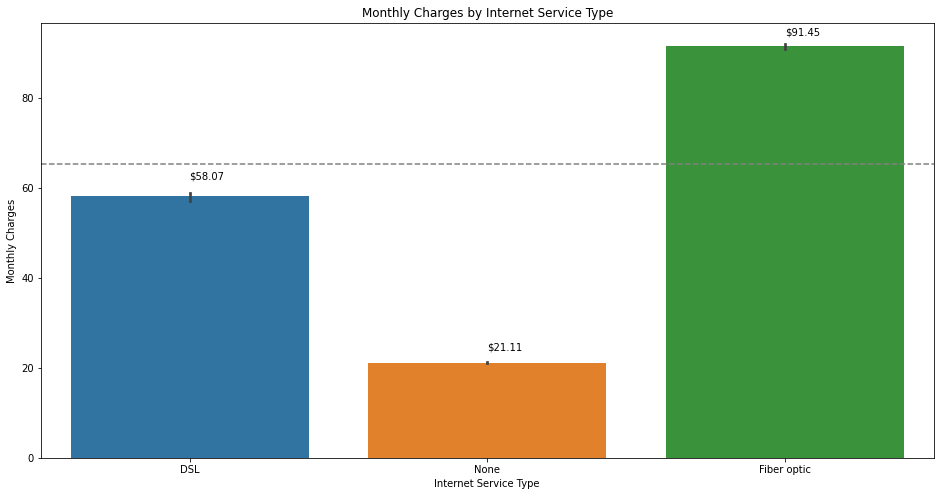

In [33]:
plt.figure(figsize=(16, 8))

ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

mean_monthly_charges = train.monthly_charges.mean()

plt.title("Monthly Charges by Internet Service Type")
sns.barplot(train.internet_service_type, train.monthly_charges)
ax[1].axhline(mean_monthly_charges, ls='--', color='grey')
plt.text(0, 62, f"${train[train.internet_service_type == 'DSL'].monthly_charges.mean():.2f}")
plt.text(1, 24, f"${train[train.internet_service_type == 'None'].monthly_charges.mean():.2f}")
plt.text(2, 94, f"${train[train.internet_service_type == 'Fiber optic'].monthly_charges.mean():.2f}")
plt.xlabel("Internet Service Type")
plt.ylabel("Monthly Charges")
plt.show()

---
## 8.  How much of monthly_charges can be explained by phone service type?

<Figure size 1152x576 with 0 Axes>

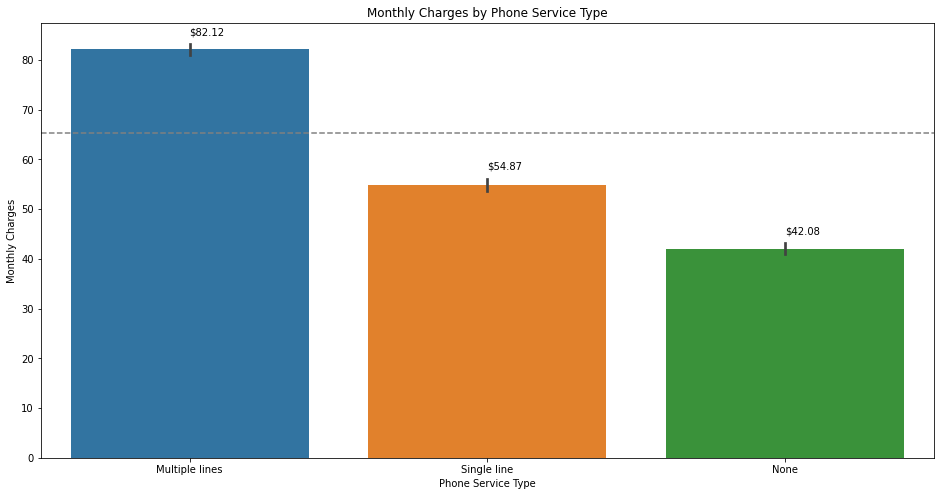

In [34]:
plt.figure(figsize=(16, 8))

ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

mean_monthly_charges = train.monthly_charges.mean()

plt.title("Monthly Charges by Phone Service Type")
sns.barplot(train.phone_service_type, train.monthly_charges)
ax[1].axhline(mean_monthly_charges, ls='--', color='grey')
plt.text(0, 85, f"${train[train.phone_service_type == 'Multiple lines'].monthly_charges.mean():.2f}")
plt.text(1, 58, f"${train[train.phone_service_type == 'Single line'].monthly_charges.mean():.2f}")
plt.text(2, 45, f"${train[train.phone_service_type == 'None'].monthly_charges.mean():.2f}")
plt.xlabel("Phone Service Type")
plt.ylabel("Monthly Charges")
plt.show()

---
# Model

1. build a function takes in all selected features, 

2. function produce accuray for each algirthom
3. logistic regression is the baseline

In [35]:
# all the feature has been already encoded with separated preparation
# split data
df = prep_data()
train, validate, test = split_data(df)
#scale datasets
scaler, train, validate, test = scale_data(train, validate, test)
train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,churn
5409,0,1,0,0.577465,1,1,2,0,0,1,1,0,0,1,1,4,0.673653,0
561,0,1,0,0.985915,1,0,3,0,0,0,0,0,0,3,0,4,0.006986,0
6297,0,0,0,0.281690,1,0,3,0,0,0,0,0,0,3,1,4,0.024451,0
5354,0,0,0,0.169014,1,0,2,0,0,0,0,0,0,1,1,2,0.516467,0
1068,0,0,0,0.591549,1,1,2,1,1,1,1,1,1,3,0,4,0.964571,0


In [36]:
# Name features 
X = train.drop(columns = 'churn').columns
y = ['churn']

In [37]:
# apply to train, validate, test
X_train = train[X]
y_train = train[y]
X_validate = validate[X]
y_validate = validate[y]
X_test = test[X]
y_test = test[y]

## 2. Make a function

In [38]:
def model_evaluation(X, y):
    # get prepared data
    df = prep_data()
    # split data
    train, validate, test = split_data(df)
    # assaign X, y to different data set
    X_train = train[X]
    y_train = train[y]
    X_validate = validate[X]
    y_validate = validate[y]
    X_test = test[X]
    y_test = test[y]
    # train different models
    ## logiestic regression
    logit = LogisticRegression(random_state = 123)
    logit.fit(X_train, y_train)
    ## random forest
    rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            #max_depth=20, 
                            random_state=123)
    rf.fit(X_train, y_train)
    ## KNN
    knn = KNeighborsClassifier(n_neighbors=6, weights='uniform')
    knn.fit(X_train, y_train)
    return pd.DataFrame({'logistic_regression': [logit.score(X_train, y_train),logit.score(X_validate, y_validate)],
              'random_forest': [rf.score(X_train, y_train),rf.score(X_validate, y_validate)], 
              'KNN': [knn.score(X_train, y_train),knn.score(X_validate, y_validate)]}, index = ['train','validate'])

## 3.  Try model performance with different features

In [39]:
df.columns

Index(['senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'internet_service_type_id', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'contract_type_id', 'paperless_billing',
       'payment_type_id', 'monthly_charges', 'churn'],
      dtype='object')

### 1. Main features

In [40]:
X = ['tenure','monthly_charges','contract_type_id','senior_citizen']
y = ['churn']
model_evaluation(X, y)

,logistic_regression,random_forest,KNN
train,0.789711,0.887387,0.827881
validate,0.798863,0.780384,0.778252


### 2. Other features

In [41]:
X = ['senior_citizen', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'internet_service_type_id', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing',
       'payment_type_id']
y = ['churn']
model_evaluation(X, y)

,logistic_regression,random_forest,KNN
train,0.766477,0.822665,0.802276
validate,0.778252,0.774698,0.755508


### 3. All features

In [42]:
X = train.drop(columns = 'churn').columns
y = ['churn']
model_evaluation(X, y)

,logistic_regression,random_forest,KNN
train,0.802039,0.891181,0.832148
validate,0.808102,0.796731,0.785359


**Takeaways**
1. `tenure`,`monthly_charges`,`contract_type_id`: these three features give me a good accuracy, by adding other features, it did not increase acurracy very much
2. I assume all the `other features` has high correlation with `onthly charges`
3. `Random_forest` algrithm generate the best model performance, so this is what we are going to use.

## 4. Apply best performance model to the test data set,  get the report and csv file

In [43]:
X = ['tenure','monthly_charges','contract_type_id','senior_citizen']
y = ['churn']
X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

In [44]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=20, 
                            random_state=123)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

### 1. classification_report

In [45]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.830036,0.627119,0.787491,0.728577,0.776098
recall,0.893514,0.494652,0.787491,0.694083,0.787491
f1-score,0.860606,0.553064,0.787491,0.706835,0.778857
support,1033.000000,374.000000,0.787491,1407.000000,1407.000000


### 2. Confusion matrix

In [46]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,923,110
1,189,185


### 3. Accuracy

In [47]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.79


### 4. Export prediction into a .csv file

In [48]:
df = ac.get_telco_data()
df = df[['customer_id','tenure','monthly_charges','contract_type_id','senior_citizen','churn']]
df.head()

,customer_id,tenure,monthly_charges,contract_type_id,senior_citizen,churn
0,0003-MKNFE,9,59.9,1,0,No
1,0013-MHZWF,9,69.4,1,0,No
2,0015-UOCOJ,7,48.2,1,1,No
3,0023-HGHWL,1,25.1,1,1,Yes
4,0032-PGELS,1,30.5,1,0,Yes


In [49]:
df[["tenure", "monthly_charges"]] = scaler.transform(df[["tenure", "monthly_charges"]])
df.head()

,customer_id,tenure,monthly_charges,contract_type_id,senior_citizen,churn
0,0003-MKNFE,0.112676,0.414172,1,0,No
1,0013-MHZWF,0.112676,0.508982,1,0,No
2,0015-UOCOJ,0.084507,0.297405,1,1,No
3,0023-HGHWL,0.000000,0.066866,1,1,Yes
4,0032-PGELS,0.000000,0.120758,1,0,Yes


In [50]:
df['predicted']= rf.predict(df[['tenure',
                                'monthly_charges',
                                'contract_type_id',
                                'senior_citizen']])

In [51]:
df.head()

,customer_id,tenure,monthly_charges,contract_type_id,senior_citizen,churn,predicted
0,0003-MKNFE,0.112676,0.414172,1,0,No,0
1,0013-MHZWF,0.112676,0.508982,1,0,No,0
2,0015-UOCOJ,0.084507,0.297405,1,1,No,0
3,0023-HGHWL,0.000000,0.066866,1,1,Yes,1
4,0032-PGELS,0.000000,0.120758,1,0,Yes,1


In [52]:
df["probability"]= rf.predict_proba(df[['tenure',
                    'monthly_charges',
                    'contract_type_id',
                    'senior_citizen']])[:, 1]

In [53]:
df.head()

,customer_id,tenure,monthly_charges,contract_type_id,senior_citizen,churn,predicted,probability
0,0003-MKNFE,0.112676,0.414172,1,0,No,0,0.145710
1,0013-MHZWF,0.112676,0.508982,1,0,No,0,0.034384
2,0015-UOCOJ,0.084507,0.297405,1,1,No,0,0.113770
3,0023-HGHWL,0.000000,0.066866,1,1,Yes,1,0.893092
4,0032-PGELS,0.000000,0.120758,1,0,Yes,1,0.834510


In [54]:
df['predicted'] = df.predicted.apply(lambda x: 'Yes' if x == 1 else 'No')
df.head()

,customer_id,tenure,monthly_charges,contract_type_id,senior_citizen,churn,predicted,probability
0,0003-MKNFE,0.112676,0.414172,1,0,No,No,0.145710
1,0013-MHZWF,0.112676,0.508982,1,0,No,No,0.034384
2,0015-UOCOJ,0.084507,0.297405,1,1,No,No,0.113770
3,0023-HGHWL,0.000000,0.066866,1,1,Yes,Yes,0.893092
4,0032-PGELS,0.000000,0.120758,1,0,Yes,Yes,0.834510


In [55]:
df = df.rename(columns = {'churn': 'actual'})
df = df[['customer_id','actual','predicted', 'probability']]
df.head()

,customer_id,actual,predicted,probability
0,0003-MKNFE,No,No,0.145710
1,0013-MHZWF,No,No,0.034384
2,0015-UOCOJ,No,No,0.113770
3,0023-HGHWL,Yes,Yes,0.893092
4,0032-PGELS,Yes,Yes,0.834510


In [56]:
#df.to_csv('prediction.csv')

## Validate function in model.py file

In [57]:
from model import model_and_prediction

In [58]:
model_and_prediction()

In [59]:
df = pd.read_csv('prediction.csv',index_col = 0)
df.head()

,customer_id,actual,predicted,probability
0,0003-MKNFE,No,No,0.146257
1,0013-MHZWF,No,No,0.216573
2,0015-UOCOJ,No,No,0.291953
3,0023-HGHWL,Yes,Yes,0.932576
4,0032-PGELS,Yes,Yes,0.800860


### Check the accuracy for the entire dataset


In [60]:
(df.actual == df.predicted).mean()

0.8424345847554039

Looks Great!